In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import fnmatch
import csv
import pickle
import warnings
import torch
import time
import multiprocessing as mp
from multiprocess import Pool
from multiprocess import Process
from copy import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

<Figure size 432x288 with 0 Axes>

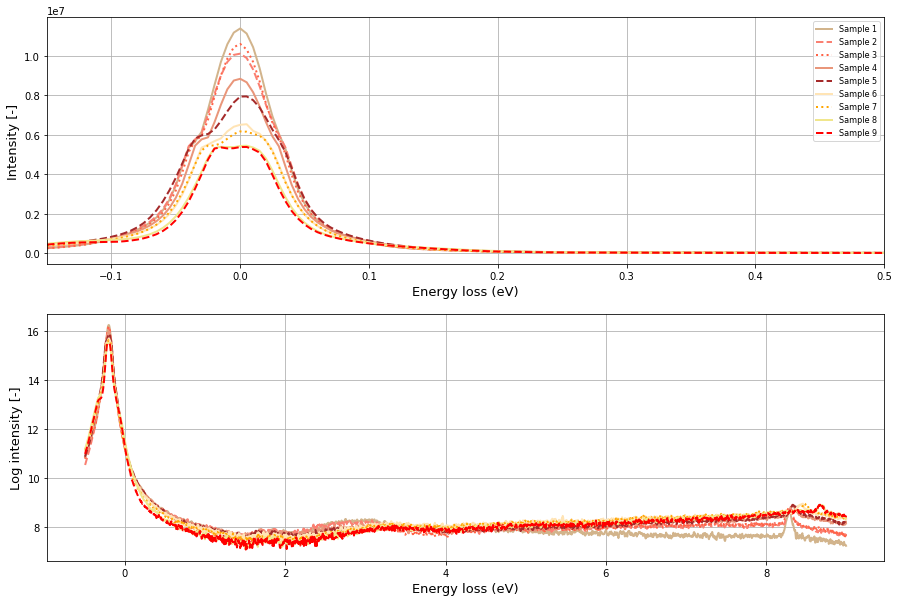

In [2]:
%run EELS-ZLP-May.py


With 1000 bins, the minimum number of training points within each bin is 9 and maximum is 18


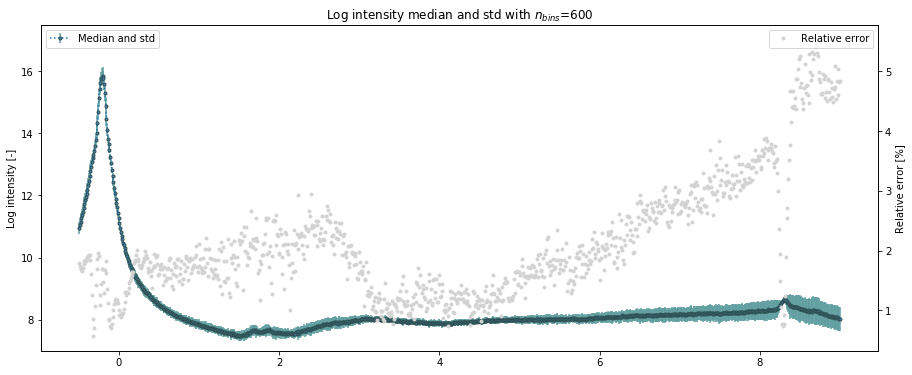

In [3]:
%run Functions.ipynb
fig = plt.gcf()

x_train = np.concatenate((x1,x2,x3,x3,x5,x6,x7,x8,x9))
logy_train = np.concatenate((log_y1, log_y2, log_y3, log_y4, log_y5, log_y6, log_y7, log_y8, log_y9))
y_train = np.concatenate((y1,y2,y3,y4,y5,y6,y7,y8,y9))
nbins = 1000
minval = min(x_train)
maxval = max(x_train)

# Store output vectors for training
df_train_log, cuts1_log, cuts2_log = ewd(x_train, logy_train, nbins)
df_train, cuts1_log, cuts2_log = ewd(x_train, y_train, nbins)
mean_log, std_log, count_log= binned_statistics(x_train, logy_train, nbins)[0:3]
mean_y, std_y, count_y= binned_statistics(x_train, y_train, nbins)[0:3]
variance_vector_log = vectorize_variance(x_train, logy_train, nbins)
variance_vector_y = vectorize_variance(x_train, y_train, nbins)
mean_vector_log = vectorize_mean(x_train, logy_train, nbins)
mean_vector_y = vectorize_mean(x_train, y_train, nbins)

# create one vector with (x_train, y_train, sigma_train)
print("With", nbins, "bins, the minimum number of training points within each bin is", int(min(count_log)), "and maximum is", int(max(count_log)))
# Create a plot of the mean & std 
plot_uncertainties(x_train, logy_train, nbins, minval, maxval)
plt.ylabel('Log intensity [-]')
ax2 = plt.twinx()
ax2.plot(np.linspace(minval, maxval, nbins), 100*np.divide(std_log, mean_log), '.', color='lightgray',  label='Relative error')
#ax2.plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.legend(['Relative error'], loc='upper right')
fig.set_size_inches(15, 6)
plt.title('Log intensity median and std with $n_{bins}$=600')
plt.xlabel('Energy loss [eV]')
plt.ylabel('Relative error [%]')
plt.show()
df_x = df_train[:,0]



In [4]:
df = pd.DataFrame()

df['x'] = df_x + 0.2025 # shift to align peak with zero loss
df['y'] = mean_vector_y
df['log_y'] = np.log(mean_vector_y)
df['sigma'] = variance_vector_log
df['real sigma'] = variance_vector_y

df.head()


,x,y,log_y,sigma,real sigma
0,-0.295,57944.627778,10.967243,0.196614,10897.05895
1,-0.295,57944.627778,10.967243,0.196614,10897.05895
2,-0.295,57944.627778,10.967243,0.196614,10897.05895
3,-0.295,57944.627778,10.967243,0.196614,10897.05895
4,-0.295,57944.627778,10.967243,0.196614,10897.05895


## Gaussian fit

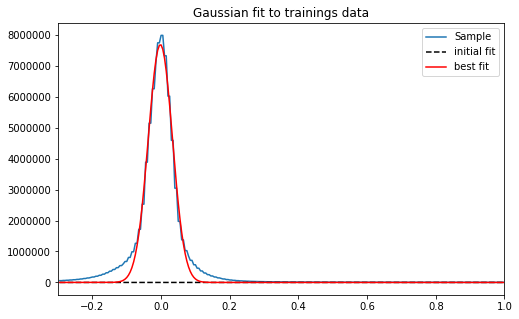

In [5]:
from lmfit import Model

def gaussian(x, amp, cen, std):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp) * np.exp(-(x-cen)**2 / (2*std**2))

gmodel = Model(gaussian)

gaussian_y = gmodel.fit(df['y'], x=df['x'], amp=1, cen=0, std=0.4)
amp10, cen10, std10 = gaussian_y.params['amp'].value, gaussian_y.params['cen'].value, gaussian_y.params['std'].value 

plt.figure(figsize=(8,5))
plt.title('Gaussian fit to trainings data')
plt.plot(df['x'], df['y'], label='Sample')
plt.plot(df['x'], gaussian_y.init_fit, 'k--', label='initial fit')
plt.plot(df['x'], gaussian_y.best_fit, 'r-', label='best fit')
plt.xlim([-.3,1])
plt.legend()

df['gaussian'] = gaussian_y.best_fit


## Closure test

In [6]:
df_closure = df.copy()

df_closure['smooth'] = smooth(df_closure['y'])
df_closure['pseudo'] = df_closure['smooth'] + df_closure['real sigma'] * np.random.rand(1)

df_closure = df_closure[df_closure['x']<1]
df_closure = df_closure.drop_duplicates()
df_closure.describe()

,x,y,log_y,sigma,real sigma,gaussian,smooth,pseudo
count,1207.000000,1.207000e+03,1207.000000,1207.000000,1.207000e+03,1.207000e+03,1.207000e+03,1.207000e+03
mean,0.352361,5.996834e+05,10.600055,0.159497,1.300985e+05,5.273796e+05,5.997061e+05,6.289203e+05
std,0.371971,1.603282e+06,2.329251,0.044569,3.775135e+05,1.618199e+06,1.599685e+06,1.683292e+06
min,-0.295000,3.100925e+03,8.039456,0.075932,3.551301e+02,1.427788e-168,3.080212e+03,3.159958e+03
25%,0.030000,5.268694e+03,8.569538,0.130620,7.196505e+02,2.035617e-74,5.294211e+03,5.474856e+03
50%,0.355000,1.622516e+04,9.694318,0.149731,2.149292e+03,2.961925e-16,1.655621e+04,1.703884e+04
75%,0.675000,2.311658e+05,12.350891,0.176597,3.681965e+04,1.845370e+02,2.251167e+05,2.358152e+05
max,0.995000,7.978663e+06,15.892281,0.288361,2.114322e+06,7.669816e+06,7.978663e+06,8.453444e+06


## Get the derivatives

In [7]:
window_len = 100
df_dx = pd.DataFrame({"x": x1, "y1": smooth(y1, window_len), "y2": smooth(y2, window_len), "y3": smooth(y3, window_len),\
                      "y4": smooth(y4, window_len), "y5": smooth(y5, window_len), "y6": smooth(y6, window_len), \
                      "y7": smooth(y7, window_len), "y8": smooth(y8, window_len), "y9": smooth(y9, window_len)})
window_len = 300
for i in range(1,9):
    df_dx['log y%(i)s' %{"i": i}] = np.log(df_dx['y%(i)s'% {"i": i}])
    df_dx['derivative y%(i)s' %{"i": i}] = np.divide(df_dx['y%(i)s'% {"i": i}].diff(), df_dx['x'].diff())
    df_dx['smooth derivative y%(i)s' %{"i": i}] = smooth(df_dx['derivative y%(i)s' %{"i": i}], window_len)
    df_dx['log derivative y%(i)s' %{"i": i}] = np.divide(df_dx['log y%(i)s'% {"i": i}].diff(), df_dx['x'].diff())
    df_dx['smooth log derivative y%(i)s' %{"i": i}] = smooth(df_dx['log derivative y%(i)s' %{"i": i}], window_len)
    df_dx['2nd derivative y%(i)s' %{"i": i}] = np.divide(df_dx['derivative y%(i)s'% {"i": i}].diff(), df_dx['x'].diff())
    df_dx['2nd log derivative y%(i)s' %{"i": i}] = np.divide(df_dx['log derivative y%(i)s'% {"i": i}].diff(), df_dx['x'].diff())   

li = []
for i in range(1,9):
    dE2 = df_dx[(df_dx['log derivative y%(i)s' %{"i": i}] > 0) & (df_dx['x'] > 0)]['x'].min()
    li.append(dE2)
    
dE2 = min(li)

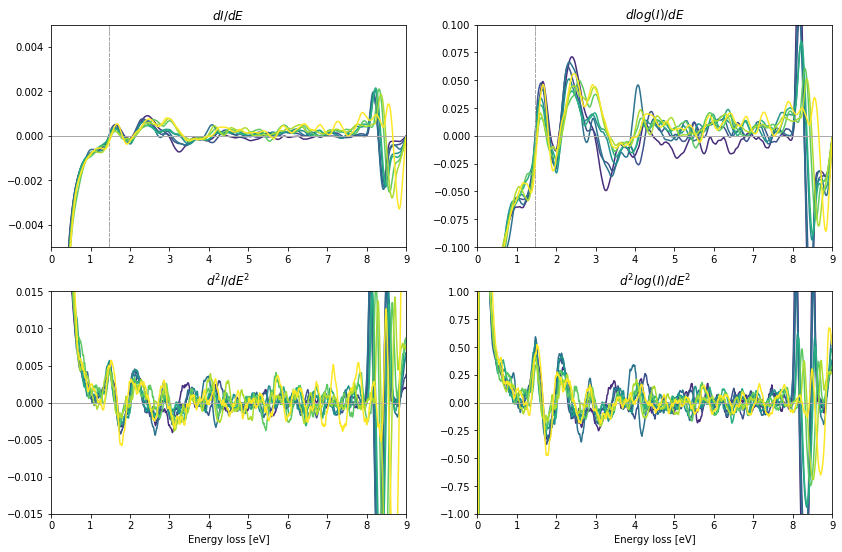

In [8]:
from matplotlib import cm
cm_subsection = np.linspace(0,1,9) 
colors = [cm.viridis(x) for x in cm_subsection ]

plt.figure(figsize=(14,9))
for i in range(1,9):
    plt.subplot(221)
    normalization = df_dx['y%(s)s' %{"s": i}].max()
    plt.axhline(y=0, color='darkgray', linewidth=1)
    plt.axvline(x=dE2, color='darkgray', linestyle='--', linewidth = 1, label='dE2')
    lognormalization = df_dx['log y%(s)s' %{"s": i}].max()
    plt.plot(df_dx['x'],df_dx['derivative y%(i)s' %{"i": i}]/normalization, color=colors[i])
    plt.title('$dI/dE$')
    plt.xlim([0,9])
    plt.ylim([-.005, .005])
    
    plt.subplot(222)
    plt.axhline(y=0, color='darkgray', linewidth=1)
    plt.axvline(x=dE2, color='darkgray', linestyle='--', linewidth = 1, label='dE2')
    plt.plot(df_dx['x'],df_dx['log derivative y%(i)s' %{"i": i}]/lognormalization, color=colors[i])
    plt.title('$dlog(I)/dE$')
    plt.xlim([0,9])
    plt.ylim([-.1, .1])
    
    
    plt.subplot(223)
    plt.axhline(y=0, color='darkgray', linewidth=1)
    #plt.axvline(x=dE2, color='darkgray', linestyle='--', linewidth = 1, label='dE2')
    plt.plot(df_dx['x'],df_dx['2nd derivative y%(i)s' %{"i": i}]/normalization, color=colors[i])
    plt.title('$d^2I/dE^2$')
    plt.xlim([0,9])
    plt.ylim([-.015, .015])
    plt.xlabel('Energy loss [eV]')
    
    
    plt.subplot(224)
    plt.axhline(y=0, color='darkgray', linewidth=1)
    #plt.axvline(x=dE2, color='darkgray', linestyle='--', linewidth = 1, label='dE2')
    plt.plot(df_dx['x'],df_dx['2nd log derivative y%(i)s' %{"i": i}]/lognormalization, color=colors[i])
    plt.title('$d^2log(I)/dE^2$')
    plt.xlim([0,9])
    plt.ylim([-1, 1])
    plt.xlabel('Energy loss [eV]')
    
plt.savefig('Figures/derivatives.png')    

## dE1 and dE2

The value of dE2 is calculated as the first time the derivative dI/dE grows to zero.

In [9]:

dE1 = dE2 / 2.5
print('The values of dE1 and dE2', dE1, dE2)

The values of dE1 and dE2 0.5870000000000001 1.4675000000000002


### Drop data for x > dE1



In [10]:
df_window = df[df['x'] <= dE1]

In [11]:
df_window.describe()

,x,y,log_y,sigma,real sigma,gaussian
count,1593.000000,1.593000e+03,1593.000000,1593.000000,1.593000e+03,1.593000e+03
mean,0.145000,8.677847e+05,11.638565,0.169688,1.888155e+05,7.650213e+05
std,0.255554,1.859917e+06,2.115583,0.050406,4.404785e+05,1.890400e+06
min,-0.295000,6.621689e+03,8.798106,0.075932,8.963162e+02,2.017359e-54
25%,-0.075000,1.547160e+04,9.646761,0.133090,2.113444e+03,1.580419e-17
50%,0.145000,9.383413e+04,11.449284,0.164834,1.599640e+04,1.638054e-02
75%,0.365000,5.434141e+05,13.205627,0.196934,7.295844e+04,4.742278e+04
max,0.585000,7.978663e+06,15.892281,0.288361,2.114322e+06,7.669816e+06


###  Find the value where the tail intensity is at $10^{-3}$ of its maximum

This is also known as the 'Kimoto Limit'.

In [12]:
kimoto_lim = max(df[df['y'] > (1e-3) * max(df['y'])]['x'])
kimoto_lim

0.5100000000000001

### Create pseudo data for $x > $dE2

In [13]:
min_x = dE2
max_x = 8.9975
N_pseudo = 30

df_pseudo = pd.DataFrame({'x':np.linspace(min_x, max_x, N_pseudo),'y': 3 * np.ones(N_pseudo), \
                    'log_y': np.log(3 * np.ones(N_pseudo)), 'sigma': .2 * np.ones(N_pseudo)})



In [14]:
#df_full = df_window

df_full = pd.concat([df_window, df_pseudo])

df_full.describe()

,gaussian,log_y,real sigma,sigma,x,y
count,1.593000e+03,1623.000000,1.593000e+03,1623.000000,1623.000000,1.623000e+03
mean,7.650213e+05,11.443741,1.888155e+05,0.170249,0.239039,8.517444e+05
std,1.890400e+06,2.531724,4.404785e+05,0.050104,0.792079,1.846342e+06
min,2.017359e-54,1.098612,8.963162e+02,0.075932,-0.295000,3.000000e+00
25%,1.580419e-17,9.551017,2.113444e+03,0.133090,-0.070000,1.405899e+04
50%,1.638054e-02,11.383970,1.599640e+04,0.165587,0.155000,8.790133e+04
75%,4.742278e+04,13.075969,7.295844e+04,0.200000,0.380000,4.773325e+05
max,7.669816e+06,15.892281,2.114322e+06,0.288361,8.997500,7.978663e+06


### Create architecture

In [15]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [16]:
tf.reset_default_graph()

x = tf.placeholder("float", [None, 1], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_train_full = df_full
df_train_full = df_train_full.drop_duplicates(subset = ['x']) # Only keep one copy per x-value
df_train, df_test = train_test_split(df_train_full, test_size=0.18, random_state=26)

N_train = len(df_train['x'])
N_test = len(df_test['x'])

train_x = np.copy(df_train['x']).reshape(N_train,1)
train_y = np.log(np.copy(df_train['y'])).reshape(N_train,1)
train_sigma = (np.copy(df_train['sigma'])).reshape(N_train,1)

test_x = np.copy(df_test['x']).reshape(N_test,1)
test_y = np.log(np.copy(df_test['y'])).reshape(N_test,1)
test_sigma = (np.copy(df_test['sigma'])).reshape(N_test,1)

predictions = make_model(x,1)
N_pred = 30000
predict_x = np.linspace(-.3,8.9975,N_pred).reshape(N_pred,1)

#train_scaler = StandardScaler()
#train_scaler.fit(train_x)
#test_scaler = StandardScaler()
#test_scaler.fit(test_x)
train_sigma.shape

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


(169, 1)

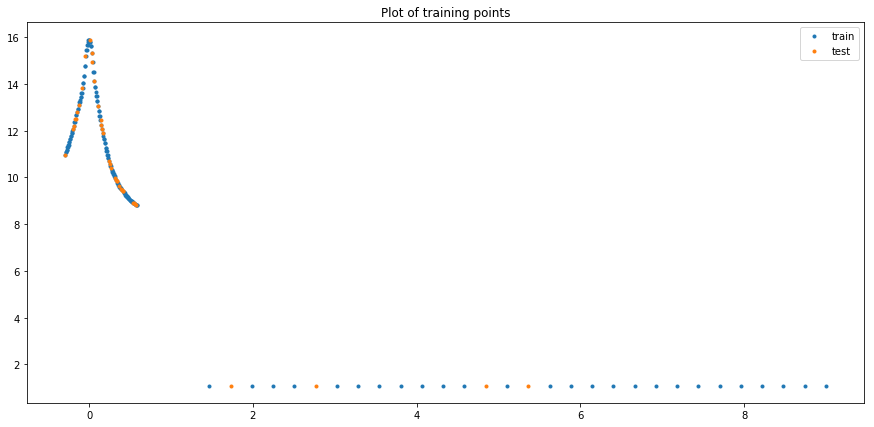

In [17]:
plt.figure(figsize=(15,7))
#plt.xlim([-0.35, -0.2])
plt.plot(train_x, train_y, '.', label='train')
plt.plot(test_x, test_y, '.', label='test')
plt.title('Plot of training points')
plt.legend()

## Create MC replicas

In [18]:
### Create array of Nrep training samples

def pseudodata(Nrep):
    
    train_y_reps = np.zeros(shape=(N_train, Nrep))
    test_y_reps = np.zeros(shape=(N_test, Nrep))
    i=0
    while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)

        i+=1 
    train_y_reps[train_y_reps < .1] = .1    
    test_y_reps[test_y_reps < .1] = .1
    std_reps = np.std(train_y_reps, axis=1)
    mean_reps = np.mean(train_y_reps, axis=1)
    
    return mean_reps, std_reps

mean_reps100, std_reps100 = pseudodata(100)
mean_reps500, std_reps500 = pseudodata(500)
mean_reps1000, std_reps1000 = pseudodata(1000)
mean_reps5000, std_reps5000 = pseudodata(5000)

In [19]:
exp100 = np.mean(mean_reps100[mean_reps100 > 5])
exp500 = np.mean(mean_reps500[mean_reps500 > 5])
exp1000 = np.mean(mean_reps1000[mean_reps1000 > 5])
exp5000 = np.mean(mean_reps5000[mean_reps5000 > 5])
exp = np.mean(train_y[train_y > 5])

std100 = np.mean(std_reps100)
std500 = np.mean(std_reps500)
std1000 = np.mean(std_reps1000)
std5000 = np.mean(std_reps5000)
std = np.mean(train_sigma)



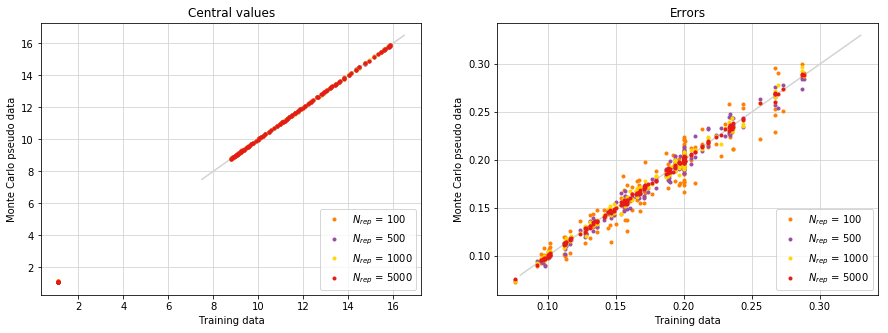

In [20]:
plt.figure(figsize=(15,5))
from matplotlib import cm
cm_subsection = np.linspace(0,1,7) 
colors = [ cm.Set1(x) for x in cm_subsection ]

plt.subplot(121)
plt.title('Central values')
plt.plot(np.linspace(7.5,16.5,10), np.linspace(7.5,16.5,10), color='lightgrey')

plt.plot(train_y, mean_reps100, '.', color = colors[3], label = '$N_{rep}$ = 100')
plt.plot(train_y, mean_reps500, '.', color = colors[2], label = '$N_{rep}$ = 500')
plt.plot(train_y, mean_reps1000, '.', color = 'gold', label = '$N_{rep}$ = 1000')
plt.plot(train_y, mean_reps5000, '.', color = colors[0], label = '$N_{rep}$ = 5000')
plt.grid(True, color='lightgray')
#plt.xlim([7,17])
#plt.ylim([7,17])
plt.xlabel(r'Training data')
plt.legend(loc='lower right')
plt.ylabel(r'Monte Carlo pseudo data')

plt.subplot(122)
plt.grid(True, color='lightgray')
plt.title('Errors')
plt.plot(np.linspace(0.08,0.33,10), np.linspace(0.08,0.33,10), color='lightgrey')
plt.plot(train_sigma, std_reps100, '.', color=colors[3], label = '$N_{rep}$ = 100')
plt.plot(train_sigma, std_reps500, '.', color=colors[2], label = '$N_{rep}$ = 500')
plt.plot(train_sigma, std_reps1000, '.', color='gold', label = '$N_{rep}$ = 1000')
plt.plot(train_sigma, std_reps5000, '.', color=colors[0], label = '$N_{rep}$ = 5000')
plt.xlabel(r'Training data')
plt.legend(loc='lower right')
#plt.xlim([0.07, 0.35])
#plt.ylim([0.07, 0.35])
plt.ylabel(r'Monte Carlo pseudo data')

plt.show()

In [21]:
Nrep = 5000

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

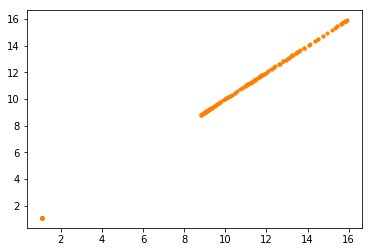

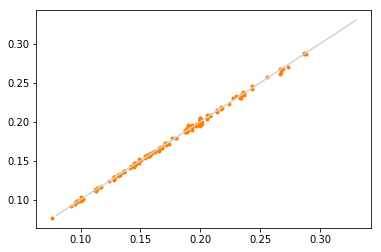

In [22]:
plt.plot(train_y, mean_reps, '.', color = colors[3], label = '$N_{rep}$ = 100')
plt.show()
plt.plot(train_sigma, std_reps, '.', color = colors[3], label = '$N_{rep}$ = 100')
plt.plot(np.linspace(0.08,0.33,10), np.linspace(0.08,0.33,10), color='lightgrey')
plt.show()

In [23]:
import time
from datetime import datetime


def function_train(it):
    
    chi_array = []
    
    processor = 'processor' + str(it)
    cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
    custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
    eta = 1e-3
    optimizer = tf.train.RMSPropOptimizer(learning_rate=eta, decay=0.9, momentum=0.0, epsilon=1e-10).minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=eta)
    saver = tf.train.Saver(max_to_keep=40)
    print("%(p)s starts training on" %{'p': processor}, '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    
    Nrep = 20

    for i in range(Nrep):

        train_y = train_y_reps[:, i+50 + it].reshape(N_train,1)
        test_y = test_y_reps[:, i+50 + it].reshape(N_test,1)
        
        ### Train and validate
        prev_test_cost = 100
        prev_epoch=0
        avg_cost = 0.0

        array_train = []
        array_test = []

        with tf.Session() as sess:
            
            sess.run(tf.global_variables_initializer())
            
            training_epochs = 40000
            max_rising_epochs = 50000 #The amount of epochs the minimzer is allowed to overfit before it stops
            display_step = 1000

            for epoch in range(training_epochs):

                _, c = sess.run([optimizer, cost], 
                                feed_dict={
                                    x: train_x,
                                    y: train_y,
                                    sigma: train_sigma
                                })

                avg_cost = c
                
                test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                    array_train.append(avg_cost)
                    array_test.append(test_cost)
                    saver.save(sess, 'Models/%(processor)s/my-model.ckpt' %{'processor': processor} , global_step=epoch , write_meta_graph=False) 

                    
                elif test_cost < prev_test_cost:
                    prev_test_cost = test_cost
                    prev_epoch = epoch

            best_iteration = np.argmin(array_test) 
            best_epoch = best_iteration * display_step
            best_model = 'Models/%(processor)s/my-model.ckpt-%(s)s' % {'processor': processor, 's': best_epoch}

            print("Optimization %(i)s Finished! Best model after epoch %(s)s" % {'i': i, 's': best_epoch})
            

            saver.restore(sess, best_model)

            predictions_values = sess.run(predictions, 
                                feed_dict={
                                    x: train_x,
                                    y: train_y 
                                }) 


            extrapolation = sess.run(predictions,
                                feed_dict={
                                    x: predict_x
                                })
            

        sess.close()
        

        now = datetime.now()

        dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
        d_string = now.strftime("%d.%m.%Y")
        t_string = now.strftime("%H:%M:%S")

        a = np.array(train_x).reshape(N_train,)
        b = np.array(train_y).reshape(N_train,)
        c = np.array(predictions_values).reshape(N_train,)
        d = array_train
        e = array_test
       
        k = np.array(predict_x).reshape(N_pred,)
        l = np.array(extrapolation).reshape(N_pred,)
        
        np.savetxt('Data/Results/%(date)s/x2_xyp1p2_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i }, list(zip(a,b,c)),  delimiter=',', fmt='%f')
        np.savetxt('Data/Results/%(date)s/x2_chi_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i }, list(zip(d,e)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/%(date)s/x2_extrapolation_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i }, list(zip(k, l)),  delimiter=',', fmt='%f')
 

## Parallel training

In [24]:
# make sure to always use multiprocess
from multiprocess import Pool
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

number_of_cores=8
# start your parallel workers at the beginning of your script
pool = Pool(number_of_cores)

# execute a computation(s) in parallel
result1 = pool.map(function_train, [1,2,3,4,5,6,7,8])

pool.close()

#print(pool)


processor4 starts training on 0169 and validating on 0038 samples
processor2 starts training on 0169 and validating on 0038 samples
processor1 starts training on 0169 and validating on 0038 samples
processor5 starts training on 0169 and validating on 0038 samples
processor3 starts training on 0169 and validating on 0038 samples
processor6 starts training on 0169 and validating on 0038 samples
processor7 starts training on 0169 and validating on 0038 samples
processor8 starts training on 0169 and validating on 0038 samples
Epoch: 0001 | Training cost= 5331.540527344 | Validation cost= 4716.097656250
Epoch: 0001 | Training cost= 5353.953125000 | Validation cost= 4686.199707031
Epoch: 0001 | Training cost= 5358.959960938 | Validation cost= 4689.708007812
Epoch: 0001 | Training cost= 5360.912109375 | Validation cost= 4705.355468750
Epoch: 0001 | Training cost= 5348.072265625 | Validation cost= 4704.036132812
Epoch: 0001 | Training cost= 5355.322265625 | Validation cost= 4738.155761719
Epoc

Epoch: 13001 | Training cost= 1.347309589 | Validation cost= 1.062605858
Epoch: 13001 | Training cost= 1.088267803 | Validation cost= 1.145134807
Epoch: 13001 | Training cost= 1.059600234 | Validation cost= 1.317839980
Epoch: 13001 | Training cost= 1.436095476 | Validation cost= 1.107821822
Epoch: 13001 | Training cost= 1.217894912 | Validation cost= 1.499940395
Epoch: 13001 | Training cost= 1.238240242 | Validation cost= 1.471488476
Epoch: 13001 | Training cost= 1.351040363 | Validation cost= 1.980599642
Epoch: 14001 | Training cost= 1.284732580 | Validation cost= 1.432763577
Epoch: 14001 | Training cost= 1.084377885 | Validation cost= 1.141999364
Epoch: 14001 | Training cost= 1.342908025 | Validation cost= 1.061255574
Epoch: 14001 | Training cost= 1.056556463 | Validation cost= 1.316714406
Epoch: 14001 | Training cost= 1.429567814 | Validation cost= 1.103050947
Epoch: 14001 | Training cost= 1.208008289 | Validation cost= 1.517158866
Epoch: 14001 | Training cost= 1.236010551 | Validat

Epoch: 27001 | Training cost= 1.284085393 | Validation cost= 1.030444384
Epoch: 27001 | Training cost= 1.011670589 | Validation cost= 1.260684609
Epoch: 27001 | Training cost= 1.369112492 | Validation cost= 1.077765465
Epoch: 27001 | Training cost= 1.177374125 | Validation cost= 1.362733483
Epoch: 27001 | Training cost= 1.127907157 | Validation cost= 1.477458119
Epoch: 27001 | Training cost= 1.267441273 | Validation cost= 1.853552580
Epoch: 28001 | Training cost= 1.035659671 | Validation cost= 1.146759510
Epoch: 28001 | Training cost= 1.267170787 | Validation cost= 1.442577600
Epoch: 28001 | Training cost= 1.008147955 | Validation cost= 1.242672801
Epoch: 28001 | Training cost= 1.276088238 | Validation cost= 1.033297420
Epoch: 28001 | Training cost= 1.364368439 | Validation cost= 1.090430617
Epoch: 28001 | Training cost= 1.171519995 | Validation cost= 1.356480598
Epoch: 28001 | Training cost= 1.129710674 | Validation cost= 1.510186553
Epoch: 28001 | Training cost= 1.266955495 | Validat

INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-22000
Optimization 0 Finished! Best model after epoch 38000
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-38000
Optimization 0 Finished! Best model after epoch 6000
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-6000
Optimization 0 Finished! Best model after epoch 27000
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-27000
Optimization 0 Finished! Best model after epoch 38000
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Models/processor8/my-model.ckpt-38000
Optimization 0 Finished! Best model af

Epoch: 9001 | Training cost= 1.411691308 | Validation cost= 1.553372979
Epoch: 9001 | Training cost= 1.380243540 | Validation cost= 1.911817431
Epoch: 9001 | Training cost= 1.537944674 | Validation cost= 1.589499712
Epoch: 9001 | Training cost= 1.602272034 | Validation cost= 2.147603512
Epoch: 9001 | Training cost= 1.478872418 | Validation cost= 1.292093635
Epoch: 9001 | Training cost= 1.392580867 | Validation cost= 1.738850594
Epoch: 9001 | Training cost= 1.895697951 | Validation cost= 1.317192674
Epoch: 9001 | Training cost= 1.394104242 | Validation cost= 1.254438281
Epoch: 10001 | Training cost= 1.393053055 | Validation cost= 1.532734394
Epoch: 10001 | Training cost= 1.358987927 | Validation cost= 1.890019417
Epoch: 10001 | Training cost= 1.518228054 | Validation cost= 1.562237978
Epoch: 10001 | Training cost= 1.459524155 | Validation cost= 1.233321786
Epoch: 10001 | Training cost= 1.578241706 | Validation cost= 2.106084347
Epoch: 10001 | Training cost= 1.370319963 | Validation cost

Epoch: 23001 | Training cost= 1.037021399 | Validation cost= 1.408795357
Epoch: 23001 | Training cost= 1.223024487 | Validation cost= 1.251675010
Epoch: 23001 | Training cost= 1.214479208 | Validation cost= 1.620380640
Epoch: 23001 | Training cost= 1.197900295 | Validation cost= 1.205840468
Epoch: 23001 | Training cost= 1.247498155 | Validation cost= 0.899393857
Epoch: 23001 | Training cost= 0.947390199 | Validation cost= 1.506145835
Epoch: 23001 | Training cost= 1.021672368 | Validation cost= 1.074880958
Epoch: 24001 | Training cost= 1.022314429 | Validation cost= 1.399101973
Epoch: 24001 | Training cost= 1.063271523 | Validation cost= 1.242132545
Epoch: 24001 | Training cost= 1.214439631 | Validation cost= 1.244595528
Epoch: 24001 | Training cost= 1.200967431 | Validation cost= 1.603323817
Epoch: 24001 | Training cost= 1.195535898 | Validation cost= 1.210078955
Epoch: 24001 | Training cost= 1.244600058 | Validation cost= 0.900230229
Epoch: 24001 | Training cost= 0.928416431 | Validat

Epoch: 37001 | Training cost= 1.179199219 | Validation cost= 1.227339983
Epoch: 37001 | Training cost= 1.177412748 | Validation cost= 1.571366906
Epoch: 37001 | Training cost= 1.186031580 | Validation cost= 1.242046714
Epoch: 37001 | Training cost= 1.221439481 | Validation cost= 0.908899426
Epoch: 37001 | Training cost= 0.885157943 | Validation cost= 1.601747990
Epoch: 38001 | Training cost= 1.013124943 | Validation cost= 1.183457494
Epoch: 37001 | Training cost= 0.914702654 | Validation cost= 1.164545178
Epoch: 38001 | Training cost= 0.979770184 | Validation cost= 1.464315772
Epoch: 38001 | Training cost= 1.177731633 | Validation cost= 1.226872087
Epoch: 38001 | Training cost= 1.177157283 | Validation cost= 1.571318150
Epoch: 38001 | Training cost= 1.185593605 | Validation cost= 1.243849874
Epoch: 38001 | Training cost= 1.220463276 | Validation cost= 0.909280360
Epoch: 38001 | Training cost= 0.884369731 | Validation cost= 1.601584435
Epoch: 39001 | Training cost= 1.012830615 | Validat

Epoch: 9001 | Training cost= 1.381515384 | Validation cost= 1.986296773
Epoch: 9001 | Training cost= 1.366700172 | Validation cost= 1.020243645
Epoch: 9001 | Training cost= 1.050832868 | Validation cost= 1.494112968
Epoch: 10001 | Training cost= 1.053771734 | Validation cost= 1.561550498
Epoch: 10001 | Training cost= 1.472468257 | Validation cost= 1.343225121
Epoch: 9001 | Training cost= 1.195620418 | Validation cost= 1.575893164
Epoch: 10001 | Training cost= 1.071902394 | Validation cost= 1.152212501
Epoch: 10001 | Training cost= 1.271063209 | Validation cost= 1.571946740
Epoch: 10001 | Training cost= 1.379736185 | Validation cost= 1.930270910
Epoch: 10001 | Training cost= 1.356908798 | Validation cost= 1.043326974
Epoch: 10001 | Training cost= 1.057110429 | Validation cost= 1.532186866
Epoch: 11001 | Training cost= 1.061481953 | Validation cost= 1.581905603
Epoch: 11001 | Training cost= 1.476124525 | Validation cost= 1.347152114
Epoch: 10001 | Training cost= 1.180270433 | Validation 

Epoch: 23001 | Training cost= 1.185432434 | Validation cost= 1.410082579
Epoch: 23001 | Training cost= 1.321643591 | Validation cost= 1.066089988
Epoch: 24001 | Training cost= 1.039535403 | Validation cost= 1.556924105
Epoch: 23001 | Training cost= 1.150872827 | Validation cost= 1.546390653
Epoch: 24001 | Training cost= 1.434782863 | Validation cost= 1.700481057
Epoch: 24001 | Training cost= 1.038636565 | Validation cost= 1.164274454
Epoch: 24001 | Training cost= 1.031623006 | Validation cost= 1.562912345
Epoch: 24001 | Training cost= 1.315986872 | Validation cost= 1.948173761
Epoch: 24001 | Training cost= 1.172309399 | Validation cost= 1.382650256
Epoch: 24001 | Training cost= 1.321361780 | Validation cost= 1.077867627
Epoch: 25001 | Training cost= 1.028831005 | Validation cost= 1.536410093
Epoch: 24001 | Training cost= 1.144694328 | Validation cost= 1.546315074
Epoch: 25001 | Training cost= 1.437858939 | Validation cost= 1.758493066
Epoch: 25001 | Training cost= 1.028651714 | Validat

Epoch: 37001 | Training cost= 1.265301108 | Validation cost= 1.164064050
Epoch: 38001 | Training cost= 0.992166579 | Validation cost= 1.501478791
Epoch: 37001 | Training cost= 1.113725066 | Validation cost= 1.500981927
Epoch: 38001 | Training cost= 1.356485724 | Validation cost= 2.170539141
Epoch: 38001 | Training cost= 0.987594783 | Validation cost= 1.171446800
Epoch: 38001 | Training cost= 1.007690907 | Validation cost= 1.645634174
Epoch: 38001 | Training cost= 1.099753618 | Validation cost= 1.285809398
Epoch: 38001 | Training cost= 1.247681618 | Validation cost= 2.494483471
Epoch: 38001 | Training cost= 1.266122818 | Validation cost= 1.184975505
Epoch: 39001 | Training cost= 0.989159644 | Validation cost= 1.499228835
Epoch: 38001 | Training cost= 1.127754569 | Validation cost= 1.517844558
Epoch: 39001 | Training cost= 1.350700378 | Validation cost= 2.163279533
Epoch: 39001 | Training cost= 0.982294321 | Validation cost= 1.166919827
Epoch: 39001 | Training cost= 1.006697416 | Validat

Epoch: 9001 | Training cost= 1.243801594 | Validation cost= 1.461246848
Epoch: 10001 | Training cost= 1.483688116 | Validation cost= 1.300373077
Epoch: 10001 | Training cost= 1.524070263 | Validation cost= 1.564738154
Epoch: 10001 | Training cost= 1.133725286 | Validation cost= 1.101634860
Epoch: 10001 | Training cost= 1.250457048 | Validation cost= 1.195937872
Epoch: 10001 | Training cost= 1.760437608 | Validation cost= 1.639160514
Epoch: 10001 | Training cost= 1.479675531 | Validation cost= 2.008748531
Epoch: 11001 | Training cost= 1.167651892 | Validation cost= 1.150210381
Epoch: 10001 | Training cost= 1.215104938 | Validation cost= 1.452272534
Epoch: 11001 | Training cost= 1.462373853 | Validation cost= 1.292356133
Epoch: 11001 | Training cost= 1.469368100 | Validation cost= 1.562271476
Epoch: 11001 | Training cost= 1.116057992 | Validation cost= 1.075962424
Epoch: 11001 | Training cost= 1.235465288 | Validation cost= 1.179717064
Epoch: 11001 | Training cost= 1.700761437 | Validati

Epoch: 23001 | Training cost= 1.076476216 | Validation cost= 1.442993164
Epoch: 24001 | Training cost= 1.247016668 | Validation cost= 1.477930427
Epoch: 24001 | Training cost= 1.465615869 | Validation cost= 1.350998282
Epoch: 24001 | Training cost= 1.017245412 | Validation cost= 1.005717874
Epoch: 24001 | Training cost= 1.124008179 | Validation cost= 1.093136907
Epoch: 25001 | Training cost= 1.096215725 | Validation cost= 1.056160927
Epoch: 24001 | Training cost= 1.337101817 | Validation cost= 1.790288448
Epoch: 25001 | Training cost= 1.375296831 | Validation cost= 1.207278848
Epoch: 24001 | Training cost= 1.070332289 | Validation cost= 1.444206357
Epoch: 25001 | Training cost= 1.243683338 | Validation cost= 1.477132201
Epoch: 25001 | Training cost= 1.458090067 | Validation cost= 1.349118829
Epoch: 25001 | Training cost= 1.012966752 | Validation cost= 1.002756119
Epoch: 25001 | Training cost= 1.117604494 | Validation cost= 1.094460845
Epoch: 26001 | Training cost= 1.093122602 | Validat

Epoch: 38001 | Training cost= 1.196423531 | Validation cost= 1.498944759
Epoch: 38001 | Training cost= 1.432641506 | Validation cost= 1.319983959
Epoch: 38001 | Training cost= 0.980721712 | Validation cost= 0.970139027
Epoch: 39001 | Training cost= 1.062456131 | Validation cost= 1.042892218
Epoch: 38001 | Training cost= 1.062740564 | Validation cost= 1.146695733
Epoch: 38001 | Training cost= 1.304795504 | Validation cost= 1.735495329
Epoch: 39001 | Training cost= 1.349036813 | Validation cost= 1.146106839
Epoch: 38001 | Training cost= 1.021593213 | Validation cost= 1.478931069
Epoch: 39001 | Training cost= 1.194228649 | Validation cost= 1.500967026
Epoch: 39001 | Training cost= 1.431315899 | Validation cost= 1.317598820
Optimization 3 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor7/my-model.ckpt-39000
Epoch: 39001 | Training cost= 0.979147732 | Validation cost= 0.968271673
Epoch: 39001 | Training cost= 1.060226440 | Validation cost= 1.

Epoch: 11001 | Training cost= 0.957105577 | Validation cost= 0.692316771
Epoch: 10001 | Training cost= 1.167726159 | Validation cost= 1.509620190
Epoch: 10001 | Training cost= 1.005138397 | Validation cost= 1.401823282
Epoch: 10001 | Training cost= 1.117510557 | Validation cost= 1.101205111
Epoch: 11001 | Training cost= 1.248527050 | Validation cost= 1.593899131
Epoch: 10001 | Training cost= 1.039527893 | Validation cost= 0.980757654
Epoch: 11001 | Training cost= 1.311178684 | Validation cost= 0.965375781
Epoch: 11001 | Training cost= 1.008922338 | Validation cost= 1.563292623
Epoch: 12001 | Training cost= 0.942930758 | Validation cost= 0.689082742
Epoch: 11001 | Training cost= 0.958089054 | Validation cost= 1.356992245
Epoch: 11001 | Training cost= 1.115862370 | Validation cost= 1.482425928
Epoch: 11001 | Training cost= 1.071123242 | Validation cost= 1.084416270
Epoch: 12001 | Training cost= 1.229279876 | Validation cost= 1.584860206
Epoch: 11001 | Training cost= 1.010220051 | Validat

Epoch: 24001 | Training cost= 0.894692063 | Validation cost= 1.158964634
Epoch: 24001 | Training cost= 0.984965146 | Validation cost= 1.489216328
Epoch: 24001 | Training cost= 0.839242816 | Validation cost= 1.239702702
Epoch: 25001 | Training cost= 1.174171209 | Validation cost= 1.615098000
Epoch: 24001 | Training cost= 0.909457445 | Validation cost= 0.987764239
Epoch: 25001 | Training cost= 1.211865544 | Validation cost= 0.856242836
Epoch: 25001 | Training cost= 0.892874360 | Validation cost= 1.556788683
Epoch: 26001 | Training cost= 0.870742440 | Validation cost= 0.706213415
Epoch: 25001 | Training cost= 0.892995000 | Validation cost= 1.163449764
Epoch: 25001 | Training cost= 0.838687599 | Validation cost= 1.239022374
Epoch: 25001 | Training cost= 0.983477056 | Validation cost= 1.494914055
Epoch: 26001 | Training cost= 1.173494101 | Validation cost= 1.615927458
Epoch: 25001 | Training cost= 0.908035934 | Validation cost= 0.987583756
Epoch: 26001 | Training cost= 1.210493326 | Validat

Epoch: 38001 | Training cost= 0.835033596 | Validation cost= 1.233938694
Epoch: 38001 | Training cost= 0.972247124 | Validation cost= 1.547744989
Epoch: 39001 | Training cost= 1.168376088 | Validation cost= 1.617703676
Epoch: 38001 | Training cost= 0.894500434 | Validation cost= 0.990063906
Epoch: 39001 | Training cost= 1.198459625 | Validation cost= 0.843864441
Optimization 4 Finished! Best model after epoch 15000
INFO:tensorflow:Restoring parameters from Models/processor7/my-model.ckpt-15000
Epoch: 39001 | Training cost= 0.886770666 | Validation cost= 1.561634064
Epoch: 39001 | Training cost= 0.877045572 | Validation cost= 1.190544963
Epoch: 39001 | Training cost= 0.834864438 | Validation cost= 1.233605146
Epoch: 39001 | Training cost= 0.971745133 | Validation cost= 1.550745845
Optimization 4 Finished! Best model after epoch 13000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-13000
Epoch: 0001 | Training cost= 6673.455566406 | Validation cost= 5949.6132812

Epoch: 11001 | Training cost= 1.117939234 | Validation cost= 1.212407351
Epoch: 11001 | Training cost= 1.416323543 | Validation cost= 1.952970028
Epoch: 12001 | Training cost= 1.151701450 | Validation cost= 1.589345217
Epoch: 10001 | Training cost= 1.106439471 | Validation cost= 0.969024658
Epoch: 11001 | Training cost= 1.099143267 | Validation cost= 1.071833611
Epoch: 11001 | Training cost= 1.223175764 | Validation cost= 1.503821373
Epoch: 11001 | Training cost= 1.427475810 | Validation cost= 1.257187843
Epoch: 11001 | Training cost= 1.096672058 | Validation cost= 1.638090611
Epoch: 12001 | Training cost= 1.110493898 | Validation cost= 1.213370085
Epoch: 12001 | Training cost= 1.404476047 | Validation cost= 1.973444700
Epoch: 11001 | Training cost= 1.096647382 | Validation cost= 0.965018094
Epoch: 13001 | Training cost= 1.152649999 | Validation cost= 1.589707375
Epoch: 12001 | Training cost= 1.096026182 | Validation cost= 1.069746852
Epoch: 12001 | Training cost= 1.197569609 | Validat

Epoch: 25001 | Training cost= 1.345160484 | Validation cost= 1.920382500
Epoch: 26001 | Training cost= 1.110908866 | Validation cost= 1.503215671
Epoch: 24001 | Training cost= 1.006206751 | Validation cost= 0.910200417
Epoch: 25001 | Training cost= 1.128600597 | Validation cost= 1.475777149
Epoch: 25001 | Training cost= 1.069842458 | Validation cost= 1.051189542
Epoch: 26001 | Training cost= 1.048431516 | Validation cost= 1.182455182
Epoch: 25001 | Training cost= 1.391579866 | Validation cost= 1.197778702
Epoch: 25001 | Training cost= 1.050248623 | Validation cost= 1.651079059
Epoch: 26001 | Training cost= 1.346421480 | Validation cost= 1.960066915
Epoch: 27001 | Training cost= 1.100098848 | Validation cost= 1.487050653
Epoch: 25001 | Training cost= 0.995246768 | Validation cost= 0.924348354
Epoch: 26001 | Training cost= 1.128850698 | Validation cost= 1.470756769
Epoch: 26001 | Training cost= 1.069538236 | Validation cost= 1.047536016
Epoch: 27001 | Training cost= 1.050176859 | Validat

Optimization 5 Finished! Best model after epoch 37000
INFO:tensorflow:Restoring parameters from Models/processor7/my-model.ckpt-37000
Epoch: 38001 | Training cost= 0.940793097 | Validation cost= 0.886781514
Epoch: 39001 | Training cost= 1.080985665 | Validation cost= 1.469129205
Optimization 5 Finished! Best model after epoch 35000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-35000
Epoch: 39001 | Training cost= 1.047393799 | Validation cost= 1.030940056
Epoch: 39001 | Training cost= 1.391384721 | Validation cost= 1.211572528
Epoch: 39001 | Training cost= 1.017806888 | Validation cost= 1.624974728
Epoch: 0001 | Training cost= 4939.442871094 | Validation cost= 4354.173828125
Optimization 5 Finished! Best model after epoch 36000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-36000
Epoch: 0001 | Training cost= 4977.237304688 | Validation cost= 4373.564453125
Epoch: 39001 | Training cost= 0.937037826 | Validation cost= 0.874423563
Opti

Epoch: 11001 | Training cost= 1.436093807 | Validation cost= 1.815901279
Epoch: 12001 | Training cost= 1.383701801 | Validation cost= 1.881591439
Epoch: 11001 | Training cost= 1.362380028 | Validation cost= 1.481632471
Epoch: 11001 | Training cost= 1.262489200 | Validation cost= 1.070668221
Epoch: 11001 | Training cost= 1.577080488 | Validation cost= 1.187264919
Epoch: 12001 | Training cost= 1.371334314 | Validation cost= 1.364826202
Epoch: 13001 | Training cost= 1.756282330 | Validation cost= 1.188659668
Epoch: 11001 | Training cost= 1.445255399 | Validation cost= 2.010044813
Epoch: 12001 | Training cost= 1.376493335 | Validation cost= 1.776320577
Epoch: 13001 | Training cost= 1.345415950 | Validation cost= 1.857235312
Epoch: 12001 | Training cost= 1.314149976 | Validation cost= 1.418564200
Epoch: 12001 | Training cost= 1.208943963 | Validation cost= 1.011738777
Epoch: 12001 | Training cost= 1.518790841 | Validation cost= 1.115531325
Epoch: 13001 | Training cost= 1.334735990 | Validat

Epoch: 25001 | Training cost= 1.081495285 | Validation cost= 1.166239023
Epoch: 26001 | Training cost= 1.129776835 | Validation cost= 1.603529811
Epoch: 25001 | Training cost= 1.002939820 | Validation cost= 0.777329981
Epoch: 26001 | Training cost= 1.084487319 | Validation cost= 1.209215760
Epoch: 25001 | Training cost= 1.215466142 | Validation cost= 0.890549183
Epoch: 27001 | Training cost= 1.454234481 | Validation cost= 1.095821142
Epoch: 26001 | Training cost= 1.072549224 | Validation cost= 1.621817470
Epoch: 25001 | Training cost= 1.044799209 | Validation cost= 1.474684119
Epoch: 26001 | Training cost= 1.073595524 | Validation cost= 1.153660893
Epoch: 27001 | Training cost= 1.119654417 | Validation cost= 1.592796326
Epoch: 26001 | Training cost= 0.996544838 | Validation cost= 0.771618009
Epoch: 26001 | Training cost= 1.202843785 | Validation cost= 0.886592150
Epoch: 27001 | Training cost= 1.071681142 | Validation cost= 1.203560829
Epoch: 28001 | Training cost= 1.440217376 | Validat

Optimization 6 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-39000
Epoch: 39001 | Training cost= 0.995785117 | Validation cost= 1.109641671
Epoch: 39001 | Training cost= 0.946657538 | Validation cost= 0.746303082
Epoch: 0001 | Training cost= 4701.215332031 | Validation cost= 4157.283691406
Optimization 6 Finished! Best model after epoch 33000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-33000
Epoch: 39001 | Training cost= 1.101634026 | Validation cost= 0.903728366
Epoch: 0001 | Training cost= 4706.313964844 | Validation cost= 4142.860351562
Optimization 6 Finished! Best model after epoch 33000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-33000
Epoch: 39001 | Training cost= 0.931313157 | Validation cost= 1.324004531
Epoch: 0001 | Training cost= 4725.656738281 | Validation cost= 4162.116699219
Optimization 6 Finished! Best model after epoch 35000
INFO:tensorflow:Re

Epoch: 12001 | Training cost= 1.311217070 | Validation cost= 1.754560590
Epoch: 13001 | Training cost= 1.312875867 | Validation cost= 1.236469626
Epoch: 11001 | Training cost= 1.309174538 | Validation cost= 1.434719443
Epoch: 12001 | Training cost= 1.265452147 | Validation cost= 1.358478904
Epoch: 11001 | Training cost= 1.609289169 | Validation cost= 1.407461286
Epoch: 12001 | Training cost= 1.144287109 | Validation cost= 1.003188133
Epoch: 12001 | Training cost= 1.305832148 | Validation cost= 1.648396730
Epoch: 13001 | Training cost= 1.378844976 | Validation cost= 1.876076698
Epoch: 13001 | Training cost= 1.295588851 | Validation cost= 1.739158988
Epoch: 12001 | Training cost= 1.276296377 | Validation cost= 1.455765724
Epoch: 14001 | Training cost= 1.255670071 | Validation cost= 1.197408915
Epoch: 13001 | Training cost= 1.254471064 | Validation cost= 1.342439532
Epoch: 12001 | Training cost= 1.533313632 | Validation cost= 1.313902259
Epoch: 13001 | Training cost= 1.076361060 | Validat

Epoch: 25001 | Training cost= 1.087074161 | Validation cost= 1.764627099
Epoch: 27001 | Training cost= 1.088978648 | Validation cost= 1.100440860
Epoch: 27001 | Training cost= 1.095303535 | Validation cost= 1.623407483
Epoch: 25001 | Training cost= 1.293356419 | Validation cost= 1.037729383
Epoch: 26001 | Training cost= 1.154101133 | Validation cost= 1.280957103
Epoch: 26001 | Training cost= 1.033562064 | Validation cost= 1.380013466
Epoch: 26001 | Training cost= 0.911278605 | Validation cost= 0.728213251
Epoch: 26001 | Training cost= 1.080955863 | Validation cost= 1.773642063
Epoch: 28001 | Training cost= 1.089367509 | Validation cost= 1.102861643
Epoch: 27001 | Training cost= 1.129514098 | Validation cost= 1.532098532
Epoch: 28001 | Training cost= 1.077820778 | Validation cost= 1.616386890
Epoch: 26001 | Training cost= 1.291269898 | Validation cost= 1.037647963
Epoch: 27001 | Training cost= 1.148479223 | Validation cost= 1.276357293
Epoch: 27001 | Training cost= 0.909576952 | Validat

Epoch: 39001 | Training cost= 0.900541306 | Validation cost= 0.718661964
Epoch: 39001 | Training cost= 1.012218237 | Validation cost= 1.745038867
Optimization 7 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-39000
Epoch: 0001 | Training cost= 5253.848144531 | Validation cost= 4694.457519531
Epoch: 1001 | Training cost= 53.441734314 | Validation cost= 43.523197174
Optimization 7 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-39000
Optimization 7 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-39000
Epoch: 39001 | Training cost= 1.276754498 | Validation cost= 1.043411374
Epoch: 0001 | Training cost= 5261.519042969 | Validation cost= 4691.567382812
Optimization 7 Finished! Best model after epoch 38000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-38000
Optimization 7 

Epoch: 12001 | Training cost= 1.443208218 | Validation cost= 1.284133077
Epoch: 13001 | Training cost= 1.104111433 | Validation cost= 1.187718272
Epoch: 12001 | Training cost= 1.166834950 | Validation cost= 1.533628821
Epoch: 11001 | Training cost= 1.318844914 | Validation cost= 1.278124094
Epoch: 14001 | Training cost= 1.186360359 | Validation cost= 1.346256375
Epoch: 13001 | Training cost= 1.103198647 | Validation cost= 1.619788170
Epoch: 12001 | Training cost= 1.129900455 | Validation cost= 1.153447151
Epoch: 13001 | Training cost= 1.075130820 | Validation cost= 0.982917786
Epoch: 13001 | Training cost= 1.437146068 | Validation cost= 1.277441740
Epoch: 14001 | Training cost= 1.094611764 | Validation cost= 1.169033289
Epoch: 12001 | Training cost= 1.304290652 | Validation cost= 1.258431554
Epoch: 13001 | Training cost= 1.155538917 | Validation cost= 1.525741220
Epoch: 15001 | Training cost= 1.170260072 | Validation cost= 1.337432504
Epoch: 14001 | Training cost= 1.089606643 | Validat

Epoch: 26001 | Training cost= 1.388181567 | Validation cost= 1.205380678
Epoch: 26001 | Training cost= 1.042828441 | Validation cost= 1.314877629
Epoch: 28001 | Training cost= 1.105194807 | Validation cost= 1.357354164
Epoch: 25001 | Training cost= 1.195979714 | Validation cost= 1.156205654
Epoch: 27001 | Training cost= 0.986504734 | Validation cost= 1.713772058
Epoch: 26001 | Training cost= 0.980091870 | Validation cost= 1.135575414
Epoch: 27001 | Training cost= 0.958231747 | Validation cost= 0.889369488
Epoch: 28001 | Training cost= 1.042211294 | Validation cost= 1.107003450
Epoch: 27001 | Training cost= 1.385548711 | Validation cost= 1.200477839
Epoch: 27001 | Training cost= 1.039528489 | Validation cost= 1.310105801
Epoch: 29001 | Training cost= 1.103661776 | Validation cost= 1.359514117
Epoch: 26001 | Training cost= 1.192921519 | Validation cost= 1.155556083
Epoch: 28001 | Training cost= 0.983708680 | Validation cost= 1.718623757
Epoch: 27001 | Training cost= 0.975646138 | Validat

Epoch: 0001 | Training cost= 5120.184570312 | Validation cost= 4533.635253906
Optimization 8 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-39000
Optimization 8 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-39000
Optimization 8 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-39000
Epoch: 1001 | Training cost= 139.269760132 | Validation cost= 110.474952698
Epoch: 0001 | Training cost= 5105.471191406 | Validation cost= 4540.935058594
Optimization 8 Finished! Best model after epoch 18000
INFO:tensorflow:Restoring parameters from Models/processor8/my-model.ckpt-18000
Epoch: 39001 | Training cost= 1.156973124 | Validation cost= 1.135163903
Epoch: 0001 | Training cost= 5104.735351562 | Validation cost= 4543.462402344
Epoch: 0001 | Training cost= 5107.716796875 | Validation cost= 4551.970214844
Epo

Epoch: 14001 | Training cost= 0.972715914 | Validation cost= 0.981909275
Epoch: 11001 | Training cost= 1.122513771 | Validation cost= 1.389326692
Epoch: 13001 | Training cost= 1.034565091 | Validation cost= 0.986542225
Epoch: 12001 | Training cost= 0.966979146 | Validation cost= 1.137467861
Epoch: 13001 | Training cost= 0.938963950 | Validation cost= 1.325564742
Epoch: 13001 | Training cost= 1.160645604 | Validation cost= 0.992766142
Epoch: 14001 | Training cost= 0.933663428 | Validation cost= 0.681168079
Epoch: 15001 | Training cost= 0.960650384 | Validation cost= 0.992372513
Epoch: 13001 | Training cost= 1.280363083 | Validation cost= 0.994232893
Epoch: 14001 | Training cost= 1.005794764 | Validation cost= 0.962271750
Epoch: 12001 | Training cost= 1.076467752 | Validation cost= 1.377140522
Epoch: 13001 | Training cost= 0.939200222 | Validation cost= 1.082273602
Epoch: 14001 | Training cost= 1.130848408 | Validation cost= 0.985169888
Epoch: 14001 | Training cost= 0.910053790 | Validat

Epoch: 27001 | Training cost= 0.913086414 | Validation cost= 0.948202610
Epoch: 25001 | Training cost= 0.976975501 | Validation cost= 1.396992087
Epoch: 26001 | Training cost= 0.868502557 | Validation cost= 0.977642655
Epoch: 27001 | Training cost= 1.056794763 | Validation cost= 1.015839815
Epoch: 27001 | Training cost= 0.845699608 | Validation cost= 1.244897962
Epoch: 28001 | Training cost= 0.882210195 | Validation cost= 0.691031158
Epoch: 29001 | Training cost= 0.915900528 | Validation cost= 1.063279152
Epoch: 27001 | Training cost= 1.215915680 | Validation cost= 0.983373821
Epoch: 28001 | Training cost= 0.912065506 | Validation cost= 0.949501812
Epoch: 26001 | Training cost= 0.975823462 | Validation cost= 1.401432991
Epoch: 27001 | Training cost= 0.867816210 | Validation cost= 0.976644039
Epoch: 28001 | Training cost= 1.055616856 | Validation cost= 1.016027093
Epoch: 28001 | Training cost= 0.845049262 | Validation cost= 1.243905902
Epoch: 29001 | Training cost= 0.881219983 | Validat

INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-15000
Epoch: 0001 | Training cost= 5283.635742188 | Validation cost= 4675.410156250
Optimization 9 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-39000
Optimization 9 Finished! Best model after epoch 16000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-16000
Epoch: 39001 | Training cost= 0.966954708 | Validation cost= 1.458881736
Epoch: 0001 | Training cost= 5283.552734375 | Validation cost= 4689.569335938
Epoch: 0001 | Training cost= 5257.939941406 | Validation cost= 4679.872558594
Optimization 9 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor8/my-model.ckpt-39000
Epoch: 1001 | Training cost= 297.911071777 | Validation cost= 233.069412231
Epoch: 2001 | Training cost= 33.518615723 | Validation cost= 26.277837753
Epoch: 0001 | Training cost= 5270.936523438 | Validation cost

Epoch: 11001 | Training cost= 1.187482595 | Validation cost= 1.308340311
Epoch: 13001 | Training cost= 1.322497249 | Validation cost= 1.489395499
Epoch: 14001 | Training cost= 1.131040335 | Validation cost= 1.485465169
Epoch: 15001 | Training cost= 1.111520767 | Validation cost= 1.198462367
Epoch: 13001 | Training cost= 1.466290951 | Validation cost= 1.109330654
Epoch: 13001 | Training cost= 1.308051467 | Validation cost= 1.357091784
Epoch: 14001 | Training cost= 1.159028649 | Validation cost= 1.025097609
Epoch: 13001 | Training cost= 1.357754827 | Validation cost= 1.079912066
Epoch: 12001 | Training cost= 1.161591887 | Validation cost= 1.299529433
Epoch: 14001 | Training cost= 1.300398111 | Validation cost= 1.446120977
Epoch: 15001 | Training cost= 1.115714908 | Validation cost= 1.443136692
Epoch: 16001 | Training cost= 1.093238592 | Validation cost= 1.167055726
Epoch: 14001 | Training cost= 1.452560186 | Validation cost= 1.105119348
Epoch: 15001 | Training cost= 1.142446876 | Validat

Epoch: 27001 | Training cost= 1.164373994 | Validation cost= 1.380379915
Epoch: 28001 | Training cost= 1.032039046 | Validation cost= 1.345671296
Epoch: 27001 | Training cost= 1.363721490 | Validation cost= 1.022057533
Epoch: 29001 | Training cost= 0.939171672 | Validation cost= 0.908336818
Epoch: 28001 | Training cost= 1.000797272 | Validation cost= 0.930411160
Epoch: 27001 | Training cost= 1.175173402 | Validation cost= 1.270886660
Epoch: 27001 | Training cost= 1.236495256 | Validation cost= 1.076236486
Epoch: 26001 | Training cost= 1.000873923 | Validation cost= 1.243354678
Epoch: 28001 | Training cost= 1.158404708 | Validation cost= 1.381358266
Epoch: 29001 | Training cost= 1.028367162 | Validation cost= 1.343908429
Epoch: 28001 | Training cost= 1.359492898 | Validation cost= 1.015616298
Epoch: 30001 | Training cost= 0.935638905 | Validation cost= 0.904154718
Epoch: 29001 | Training cost= 0.995436072 | Validation cost= 0.927657902
Epoch: 28001 | Training cost= 1.171323061 | Validat

INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-39000
Optimization 10 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-39000
Epoch: 0001 | Training cost= 5682.459472656 | Validation cost= 5017.396972656
Epoch: 0001 | Training cost= 5687.664062500 | Validation cost= 5033.488769531
Optimization 10 Finished! Best model after epoch 17000
INFO:tensorflow:Restoring parameters from Models/processor8/my-model.ckpt-17000
Epoch: 1001 | Training cost= 47.828605652 | Validation cost= 34.847770691
Epoch: 2001 | Training cost= 34.047176361 | Validation cost= 22.609920502
Epoch: 39001 | Training cost= 0.971825242 | Validation cost= 1.207870364
Epoch: 1001 | Training cost= 49.018074036 | Validation cost= 38.005176544
Epoch: 0001 | Training cost= 5701.293457031 | Validation cost= 5029.408203125
Epoch: 0001 | Training cost= 5707.339843750 | Validation cost= 5032.095214844
Epoch: 1001 | Training cost= 48.897811890 |

Epoch: 14001 | Training cost= 2.246531725 | Validation cost= 2.311834812
Epoch: 13001 | Training cost= 1.547953248 | Validation cost= 1.630915642
Epoch: 14001 | Training cost= 1.263851285 | Validation cost= 1.770094991
Epoch: 13001 | Training cost= 1.580279231 | Validation cost= 1.914238214
Epoch: 13001 | Training cost= 1.506367922 | Validation cost= 1.689469576
Epoch: 14001 | Training cost= 2.339519262 | Validation cost= 2.466128349
Epoch: 12001 | Training cost= 1.467994690 | Validation cost= 1.853004098
Epoch: 16001 | Training cost= 1.486538410 | Validation cost= 1.231227875
Epoch: 15001 | Training cost= 2.206187010 | Validation cost= 2.251838446
Epoch: 14001 | Training cost= 1.498476148 | Validation cost= 1.570002317
Epoch: 15001 | Training cost= 1.223203182 | Validation cost= 1.688138843
Epoch: 14001 | Training cost= 1.530470610 | Validation cost= 1.829098344
Epoch: 14001 | Training cost= 1.464127898 | Validation cost= 1.649443984
Epoch: 15001 | Training cost= 2.279781103 | Validat

Epoch: 27001 | Training cost= 1.292379141 | Validation cost= 1.351429939
Epoch: 28001 | Training cost= 1.098073602 | Validation cost= 1.436236978
Epoch: 27001 | Training cost= 1.260960102 | Validation cost= 1.473341107
Epoch: 27001 | Training cost= 1.299873710 | Validation cost= 1.454048395
Epoch: 30001 | Training cost= 1.323754907 | Validation cost= 1.137935758
Epoch: 26001 | Training cost= 1.056325912 | Validation cost= 1.144886374
Epoch: 28001 | Training cost= 1.677053809 | Validation cost= 1.674015999
Epoch: 29001 | Training cost= 1.838490725 | Validation cost= 1.747612238
Epoch: 28001 | Training cost= 1.289080143 | Validation cost= 1.349433661
Epoch: 29001 | Training cost= 1.095473289 | Validation cost= 1.432613134
Epoch: 28001 | Training cost= 1.253982425 | Validation cost= 1.465730667
Epoch: 28001 | Training cost= 1.295028448 | Validation cost= 1.444762349
Epoch: 31001 | Training cost= 1.318849325 | Validation cost= 1.138151050
Epoch: 27001 | Training cost= 1.047651529 | Validat

Epoch: 2001 | Training cost= 42.388450623 | Validation cost= 31.619493484
Epoch: 1001 | Training cost= 52.299377441 | Validation cost= 40.598537445
Epoch: 0001 | Training cost= 4821.233398438 | Validation cost= 4232.747558594
Epoch: 0001 | Training cost= 4838.255859375 | Validation cost= 4264.511718750
Optimization 11 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor8/my-model.ckpt-39000
Epoch: 0001 | Training cost= 4821.926269531 | Validation cost= 4253.166992188
Epoch: 1001 | Training cost= 51.987091064 | Validation cost= 36.810276031
Epoch: 39001 | Training cost= 0.996256351 | Validation cost= 1.022310376
Epoch: 3001 | Training cost= 37.108257294 | Validation cost= 28.240774155
Epoch: 0001 | Training cost= 4839.973144531 | Validation cost= 4219.448730469
Epoch: 2001 | Training cost= 42.226650238 | Validation cost= 35.367023468
Epoch: 1001 | Training cost= 50.412887573 | Validation cost= 37.424350739
Epoch: 1001 | Training cost= 49.7587

Epoch: 13001 | Training cost= 1.508658886 | Validation cost= 1.233727455
Epoch: 16001 | Training cost= 1.426944852 | Validation cost= 1.641617417
Epoch: 15001 | Training cost= 1.341870666 | Validation cost= 1.102177858
Epoch: 13001 | Training cost= 1.222049475 | Validation cost= 1.471404791
Epoch: 14001 | Training cost= 1.264289618 | Validation cost= 1.435069323
Epoch: 14001 | Training cost= 1.145905375 | Validation cost= 1.474001050
Epoch: 12001 | Training cost= 1.454747558 | Validation cost= 1.372465372
Epoch: 15001 | Training cost= 1.671441197 | Validation cost= 1.482900381
Epoch: 14001 | Training cost= 1.448520064 | Validation cost= 1.180534124
Epoch: 17001 | Training cost= 1.391884923 | Validation cost= 1.574935675
Epoch: 16001 | Training cost= 1.299995184 | Validation cost= 1.067420125
Epoch: 14001 | Training cost= 1.191460013 | Validation cost= 1.422062159
Epoch: 15001 | Training cost= 1.227032661 | Validation cost= 1.409338355
Epoch: 15001 | Training cost= 1.109847188 | Validat

Epoch: 30001 | Training cost= 1.194136620 | Validation cost= 1.190172553
Epoch: 29001 | Training cost= 1.083162427 | Validation cost= 0.957439721
Epoch: 28001 | Training cost= 1.057965755 | Validation cost= 1.298886061
Epoch: 27001 | Training cost= 0.918695509 | Validation cost= 0.936024904
Epoch: 28001 | Training cost= 0.934796393 | Validation cost= 1.090596795
Epoch: 29001 | Training cost= 1.467089772 | Validation cost= 1.262442946
Epoch: 26001 | Training cost= 1.172688365 | Validation cost= 1.057706952
Epoch: 28001 | Training cost= 0.977713048 | Validation cost= 0.907462656
Epoch: 31001 | Training cost= 1.188746572 | Validation cost= 1.179750085
Epoch: 29001 | Training cost= 1.054579020 | Validation cost= 1.299885988
Epoch: 30001 | Training cost= 1.078679681 | Validation cost= 0.967026174
Epoch: 28001 | Training cost= 0.913598120 | Validation cost= 0.924686015
Epoch: 29001 | Training cost= 0.926120460 | Validation cost= 1.072635889
Epoch: 30001 | Training cost= 1.457713604 | Validat

Epoch: 1001 | Training cost= 50.060592651 | Validation cost= 37.995933533
Epoch: 1001 | Training cost= 52.764244080 | Validation cost= 42.258884430
Epoch: 0001 | Training cost= 4764.219726562 | Validation cost= 4171.048828125
Optimization 12 Finished! Best model after epoch 38000
INFO:tensorflow:Restoring parameters from Models/processor8/my-model.ckpt-38000
Epoch: 3001 | Training cost= 32.143661499 | Validation cost= 24.477605820
Epoch: 39001 | Training cost= 1.103908777 | Validation cost= 1.026136279
Epoch: 1001 | Training cost= 52.473129272 | Validation cost= 37.704544067
Epoch: 1001 | Training cost= 53.107952118 | Validation cost= 35.511550903
Epoch: 2001 | Training cost= 39.491622925 | Validation cost= 30.680496216
Epoch: 0001 | Training cost= 4758.374023438 | Validation cost= 4165.968261719
Epoch: 2001 | Training cost= 40.795295715 | Validation cost= 34.074836731
Epoch: 1001 | Training cost= 50.757251740 | Validation cost= 39.420047760
Epoch: 4001 | Training cost= 3.391214371 | V

Epoch: 15001 | Training cost= 1.142459989 | Validation cost= 1.396975875
Epoch: 14001 | Training cost= 1.272139907 | Validation cost= 1.094712496
Epoch: 15001 | Training cost= 1.236027241 | Validation cost= 0.975878894
Epoch: 13001 | Training cost= 1.337348819 | Validation cost= 1.287121415
Epoch: 14001 | Training cost= 0.965144157 | Validation cost= 1.074125648
Epoch: 12001 | Training cost= 1.299613237 | Validation cost= 1.591161609
Epoch: 17001 | Training cost= 0.993843675 | Validation cost= 1.112701654
Epoch: 15001 | Training cost= 1.023955107 | Validation cost= 1.085690022
Epoch: 16001 | Training cost= 1.133319974 | Validation cost= 1.395685792
Epoch: 15001 | Training cost= 1.260975003 | Validation cost= 1.093711495
Epoch: 16001 | Training cost= 1.219517946 | Validation cost= 0.966484964
Epoch: 14001 | Training cost= 1.321941018 | Validation cost= 1.273114085
Epoch: 15001 | Training cost= 0.949813187 | Validation cost= 1.041327834
Epoch: 13001 | Training cost= 1.289475799 | Validat

Epoch: 28001 | Training cost= 1.196813941 | Validation cost= 1.110143781
Epoch: 29001 | Training cost= 1.135338426 | Validation cost= 0.965701342
Epoch: 27001 | Training cost= 1.206522465 | Validation cost= 1.211332798
Epoch: 28001 | Training cost= 0.897300482 | Validation cost= 0.888979971
Epoch: 31001 | Training cost= 0.938343763 | Validation cost= 1.015130401
Epoch: 26001 | Training cost= 1.179454684 | Validation cost= 1.327731133
Epoch: 29001 | Training cost= 0.957410097 | Validation cost= 1.158252597
Epoch: 30001 | Training cost= 1.083204746 | Validation cost= 1.400378227
Epoch: 30001 | Training cost= 1.133315325 | Validation cost= 0.966703892
Epoch: 29001 | Training cost= 1.195753574 | Validation cost= 1.111699104
Epoch: 28001 | Training cost= 1.202615380 | Validation cost= 1.215634704
Epoch: 29001 | Training cost= 0.896494508 | Validation cost= 0.886677504
Epoch: 32001 | Training cost= 0.936896801 | Validation cost= 1.013752818
Epoch: 27001 | Training cost= 1.177134514 | Validat

Epoch: 0001 | Training cost= 5446.688476562 | Validation cost= 4839.817871094
Optimization 13 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor8/my-model.ckpt-39000
Epoch: 39001 | Training cost= 1.158010483 | Validation cost= 1.309279919
Epoch: 1001 | Training cost= 120.663520813 | Validation cost= 106.298187256
Epoch: 2001 | Training cost= 31.299625397 | Validation cost= 24.110206604
Epoch: 2001 | Training cost= 31.676359177 | Validation cost= 22.883419037
Epoch: 1001 | Training cost= 124.487297058 | Validation cost= 101.619606018
Epoch: 0001 | Training cost= 5433.529785156 | Validation cost= 4849.419921875
Epoch: 4001 | Training cost= 1.612305284 | Validation cost= 1.701422453
Epoch: 1001 | Training cost= 121.885757446 | Validation cost= 101.862113953
Optimization 13 Finished! Best model after epoch 34000
INFO:tensorflow:Restoring parameters from Models/processor6/my-model.ckpt-34000
Epoch: 3001 | Training cost= 4.357713223 | Validation

Epoch: 17001 | Training cost= 1.248733044 | Validation cost= 1.115354061
Epoch: 13001 | Training cost= 1.223363280 | Validation cost= 1.492531657
Epoch: 14001 | Training cost= 1.217875242 | Validation cost= 1.094484210
Epoch: 12001 | Training cost= 0.992933273 | Validation cost= 1.139138818
Epoch: 16001 | Training cost= 1.162982702 | Validation cost= 1.383008242
Epoch: 16001 | Training cost= 1.043697953 | Validation cost= 1.132977962
Epoch: 15001 | Training cost= 0.977906823 | Validation cost= 1.084718347
Epoch: 15001 | Training cost= 1.223232985 | Validation cost= 1.510179996
Epoch: 18001 | Training cost= 1.235506177 | Validation cost= 1.122394323
Epoch: 14001 | Training cost= 1.220582008 | Validation cost= 1.474883556
Epoch: 15001 | Training cost= 1.210823298 | Validation cost= 1.093886495
Epoch: 13001 | Training cost= 0.998485744 | Validation cost= 1.151609063
Epoch: 17001 | Training cost= 1.162954092 | Validation cost= 1.389186502
Epoch: 16001 | Training cost= 1.219488025 | Validat

Epoch: 28001 | Training cost= 1.177636266 | Validation cost= 1.104952693
Epoch: 27001 | Training cost= 1.173083663 | Validation cost= 1.397901893
Epoch: 30001 | Training cost= 1.112388968 | Validation cost= 1.372327566
Epoch: 26001 | Training cost= 0.965693176 | Validation cost= 1.051609874
Epoch: 30001 | Training cost= 0.981479526 | Validation cost= 1.196709991
Epoch: 29001 | Training cost= 1.179045320 | Validation cost= 1.465935588
Epoch: 29001 | Training cost= 0.921614885 | Validation cost= 0.996937275
Epoch: 32001 | Training cost= 1.193030000 | Validation cost= 1.040270925
Epoch: 29001 | Training cost= 1.177560091 | Validation cost= 1.110076308
Epoch: 28001 | Training cost= 1.168123484 | Validation cost= 1.408637285
Epoch: 31001 | Training cost= 1.109801650 | Validation cost= 1.370719314
Epoch: 27001 | Training cost= 0.953605950 | Validation cost= 1.061623573
Epoch: 30001 | Training cost= 1.177452445 | Validation cost= 1.457313538
Epoch: 31001 | Training cost= 0.977582693 | Validat

Optimization 14 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor8/my-model.ckpt-39000
Epoch: 1001 | Training cost= 52.769641876 | Validation cost= 40.831489563
Epoch: 1001 | Training cost= 54.881507874 | Validation cost= 40.519416809
Epoch: 4001 | Training cost= 4.330363750 | Validation cost= 2.533337355
Epoch: 39001 | Training cost= 0.936354578 | Validation cost= 1.017379403
Epoch: 1001 | Training cost= 55.173465729 | Validation cost= 40.589149475
Epoch: 3001 | Training cost= 26.912204742 | Validation cost= 19.302419662
Epoch: 0001 | Training cost= 4998.184570312 | Validation cost= 4419.200683594
Epoch: 3001 | Training cost= 26.357376099 | Validation cost= 22.305124283
Epoch: 2001 | Training cost= 40.491569519 | Validation cost= 31.718378067
Epoch: 2001 | Training cost= 41.340724945 | Validation cost= 29.775686264
Epoch: 5001 | Training cost= 2.579798698 | Validation cost= 2.277781487
Optimization 14 Finished! Best model after epoch 380

Epoch: 13001 | Training cost= 1.385087013 | Validation cost= 1.101464391
Epoch: 16001 | Training cost= 1.040087819 | Validation cost= 1.298056602
Epoch: 12001 | Training cost= 1.852120161 | Validation cost= 1.775934339
Epoch: 15001 | Training cost= 1.046309590 | Validation cost= 1.497136235
Epoch: 15001 | Training cost= 1.274474144 | Validation cost= 1.210579515
Epoch: 18001 | Training cost= 1.210057616 | Validation cost= 1.324850917
Epoch: 15001 | Training cost= 1.344435453 | Validation cost= 1.298961878
Epoch: 17001 | Training cost= 1.031832933 | Validation cost= 1.081103683
Epoch: 14001 | Training cost= 1.321176052 | Validation cost= 1.079882979
Epoch: 17001 | Training cost= 1.030657768 | Validation cost= 1.275840282
Epoch: 13001 | Training cost= 1.802822709 | Validation cost= 1.703784108
Epoch: 16001 | Training cost= 1.012452126 | Validation cost= 1.449823141
Epoch: 16001 | Training cost= 1.264437556 | Validation cost= 1.206525326
Epoch: 19001 | Training cost= 1.195967078 | Validat

Epoch: 30001 | Training cost= 0.896881640 | Validation cost= 1.000779986
Epoch: 26001 | Training cost= 1.352505207 | Validation cost= 1.157170653
Epoch: 29001 | Training cost= 0.903740168 | Validation cost= 1.252956152
Epoch: 32001 | Training cost= 1.128816366 | Validation cost= 1.187355399
Epoch: 29001 | Training cost= 1.180537820 | Validation cost= 1.168480992
Epoch: 29001 | Training cost= 1.155364752 | Validation cost= 0.987505555
Epoch: 28001 | Training cost= 1.006386638 | Validation cost= 1.171484947
Epoch: 31001 | Training cost= 0.949125051 | Validation cost= 1.041954160
Epoch: 31001 | Training cost= 0.893656552 | Validation cost= 0.989899576
Epoch: 27001 | Training cost= 1.321686745 | Validation cost= 1.132834673
Epoch: 30001 | Training cost= 0.901733875 | Validation cost= 1.248604417
Epoch: 33001 | Training cost= 1.126957774 | Validation cost= 1.185969830
Epoch: 30001 | Training cost= 1.173561096 | Validation cost= 1.165078044
Epoch: 30001 | Training cost= 1.152023435 | Validat

Epoch: 1001 | Training cost= 51.700668335 | Validation cost= 37.239879608
Epoch: 1001 | Training cost= 54.026931763 | Validation cost= 39.798694611
Epoch: 39001 | Training cost= 1.111183286 | Validation cost= 1.050949216
Epoch: 1001 | Training cost= 51.565372467 | Validation cost= 38.595245361
Epoch: 0001 | Training cost= 5099.850585938 | Validation cost= 4500.512695312
Epoch: 3001 | Training cost= 10.357458115 | Validation cost= 12.233273506
Epoch: 3001 | Training cost= 10.369034767 | Validation cost= 9.520802498
Epoch: 5001 | Training cost= 2.656438589 | Validation cost= 3.067747116
Epoch: 2001 | Training cost= 30.719753265 | Validation cost= 22.917993546
Epoch: 2001 | Training cost= 32.528682709 | Validation cost= 23.585311890
Optimization 15 Finished! Best model after epoch 35000
INFO:tensorflow:Restoring parameters from Models/processor6/my-model.ckpt-35000
Epoch: 2001 | Training cost= 31.719917297 | Validation cost= 23.388956070
Epoch: 1001 | Training cost= 53.803977966 | Validat

Epoch: 18001 | Training cost= 1.269643426 | Validation cost= 1.357244134
Epoch: 15001 | Training cost= 1.443672180 | Validation cost= 1.497026801
Epoch: 12001 | Training cost= 1.544820428 | Validation cost= 2.072752953
Epoch: 15001 | Training cost= 1.126433015 | Validation cost= 1.229482770
Epoch: 14001 | Training cost= 1.431208372 | Validation cost= 1.483011842
Epoch: 17001 | Training cost= 1.170337200 | Validation cost= 1.640836358
Epoch: 19001 | Training cost= 1.247137070 | Validation cost= 1.354259849
Epoch: 16001 | Training cost= 1.464857459 | Validation cost= 1.681249738
Epoch: 17001 | Training cost= 1.438408256 | Validation cost= 1.209918380
Epoch: 16001 | Training cost= 1.416768789 | Validation cost= 1.469182849
Epoch: 13001 | Training cost= 1.490062356 | Validation cost= 1.960447669
Epoch: 16001 | Training cost= 1.101499438 | Validation cost= 1.188887596
Epoch: 18001 | Training cost= 1.143332839 | Validation cost= 1.591116905
Epoch: 15001 | Training cost= 1.387841702 | Validat

Epoch: 29001 | Training cost= 1.290148139 | Validation cost= 1.366364837
Epoch: 26001 | Training cost= 1.237463117 | Validation cost= 1.537995338
Epoch: 29001 | Training cost= 0.996855080 | Validation cost= 1.019749999
Epoch: 30001 | Training cost= 1.306023598 | Validation cost= 1.425827384
Epoch: 31001 | Training cost= 0.996206522 | Validation cost= 1.266794920
Epoch: 31001 | Training cost= 1.285887718 | Validation cost= 1.156266332
Epoch: 28001 | Training cost= 1.139335871 | Validation cost= 1.344708443
Epoch: 33001 | Training cost= 1.145212173 | Validation cost= 1.352216840
Epoch: 30001 | Training cost= 1.286674142 | Validation cost= 1.361706138
Epoch: 27001 | Training cost= 1.232126951 | Validation cost= 1.529009581
Epoch: 30001 | Training cost= 0.994569242 | Validation cost= 1.016303658
Epoch: 31001 | Training cost= 1.301473498 | Validation cost= 1.416213036
Epoch: 32001 | Training cost= 0.992391467 | Validation cost= 1.255354643
Epoch: 32001 | Training cost= 1.281253219 | Validat

Epoch: 39001 | Training cost= 1.202347517 | Validation cost= 1.463025093
Epoch: 3001 | Training cost= 4.186483860 | Validation cost= 4.026521206
Epoch: 2001 | Training cost= 26.689992905 | Validation cost= 18.569440842
Epoch: 5001 | Training cost= 1.486845613 | Validation cost= 1.309517264
Epoch: 3001 | Training cost= 4.313871861 | Validation cost= 4.475912094
Epoch: 0001 | Training cost= 5244.087890625 | Validation cost= 4558.645507812
Epoch: 2001 | Training cost= 26.783506393 | Validation cost= 20.010442734
Epoch: 2001 | Training cost= 11.097235680 | Validation cost= 12.685751915
Optimization 16 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor6/my-model.ckpt-39000
Epoch: 4001 | Training cost= 1.625936508 | Validation cost= 1.445611477
Epoch: 3001 | Training cost= 4.364075661 | Validation cost= 4.439718246
Epoch: 4001 | Training cost= 1.626042604 | Validation cost= 1.624327183
Epoch: 6001 | Training cost= 1.380113363 | Validation cost= 

Epoch: 15001 | Training cost= 1.283462405 | Validation cost= 1.353942513
Epoch: 17001 | Training cost= 1.274248242 | Validation cost= 1.070232868
Epoch: 17001 | Training cost= 1.269110203 | Validation cost= 1.408982158
Epoch: 19001 | Training cost= 1.097950220 | Validation cost= 1.389278412
Epoch: 16001 | Training cost= 1.268804431 | Validation cost= 1.513187885
Epoch: 14001 | Training cost= 1.170385718 | Validation cost= 1.456067324
Epoch: 16001 | Training cost= 1.068523645 | Validation cost= 1.188880563
Epoch: 16001 | Training cost= 1.270701766 | Validation cost= 1.305363774
Epoch: 13001 | Training cost= 1.197602510 | Validation cost= 1.291034341
Epoch: 18001 | Training cost= 1.285950065 | Validation cost= 1.077243447
Epoch: 18001 | Training cost= 1.267739773 | Validation cost= 1.419922471
Epoch: 17001 | Training cost= 1.262332559 | Validation cost= 1.513995290
Epoch: 20001 | Training cost= 1.092373013 | Validation cost= 1.382374048
Epoch: 15001 | Training cost= 1.158142686 | Validat

Epoch: 31001 | Training cost= 1.233508110 | Validation cost= 1.081447959
Epoch: 30001 | Training cost= 1.201937556 | Validation cost= 1.479101896
Epoch: 33001 | Training cost= 1.062936187 | Validation cost= 1.398950219
Epoch: 31001 | Training cost= 1.250664592 | Validation cost= 1.429686189
Epoch: 28001 | Training cost= 1.091195226 | Validation cost= 1.354872227
Epoch: 30001 | Training cost= 1.040501237 | Validation cost= 1.169401526
Epoch: 30001 | Training cost= 1.174126506 | Validation cost= 1.208117127
Epoch: 27001 | Training cost= 1.143315792 | Validation cost= 1.264000535
Epoch: 32001 | Training cost= 1.231796145 | Validation cost= 1.082422018
Epoch: 31001 | Training cost= 1.200295210 | Validation cost= 1.472356677
Epoch: 34001 | Training cost= 1.056726456 | Validation cost= 1.389379501
Epoch: 32001 | Training cost= 1.249051213 | Validation cost= 1.427399278
Epoch: 29001 | Training cost= 1.090682268 | Validation cost= 1.352233410
Epoch: 31001 | Training cost= 1.038169861 | Validat

Epoch: 5001 | Training cost= 2.918555260 | Validation cost= 2.297156334
Epoch: 3001 | Training cost= 22.053653717 | Validation cost= 15.920509338
Epoch: 2001 | Training cost= 38.519355774 | Validation cost= 28.647647858
Epoch: 2001 | Training cost= 39.366596222 | Validation cost= 27.998224258
Epoch: 0001 | Training cost= 5247.749023438 | Validation cost= 4641.459960938
Epoch: 4001 | Training cost= 4.091989517 | Validation cost= 2.212527752
Optimization 17 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor6/my-model.ckpt-39000
Epoch: 3001 | Training cost= 19.546836853 | Validation cost= 14.327071190
Epoch: 6001 | Training cost= 2.164205790 | Validation cost= 1.845015526
Epoch: 4001 | Training cost= 3.925510406 | Validation cost= 2.727723360
Epoch: 3001 | Training cost= 19.710880280 | Validation cost= 14.439621925
Epoch: 0001 | Training cost= 5251.579101562 | Validation cost= 4621.202148438
Epoch: 3001 | Training cost= 20.838647842 | Validat

Epoch: 16001 | Training cost= 1.146554708 | Validation cost= 1.188691974
Epoch: 17001 | Training cost= 1.015518665 | Validation cost= 1.222634792
Epoch: 13001 | Training cost= 1.156751752 | Validation cost= 1.297474980
Epoch: 16001 | Training cost= 1.250624657 | Validation cost= 1.322208047
Epoch: 16001 | Training cost= 1.221315503 | Validation cost= 1.533767223
Epoch: 18001 | Training cost= 1.359489560 | Validation cost= 1.537767768
Epoch: 14001 | Training cost= 1.123346448 | Validation cost= 1.147816300
Epoch: 20001 | Training cost= 1.025050282 | Validation cost= 1.506144404
Epoch: 17001 | Training cost= 1.139083505 | Validation cost= 1.197293878
Epoch: 18001 | Training cost= 1.010089278 | Validation cost= 1.213409066
Epoch: 14001 | Training cost= 1.152141809 | Validation cost= 1.300946116
Epoch: 17001 | Training cost= 1.245120764 | Validation cost= 1.324348688
Epoch: 17001 | Training cost= 1.216266751 | Validation cost= 1.519519448
Epoch: 19001 | Training cost= 1.351129770 | Validat

Epoch: 31001 | Training cost= 0.950242817 | Validation cost= 1.130513310
Epoch: 27001 | Training cost= 1.091563702 | Validation cost= 1.275537372
Epoch: 30001 | Training cost= 1.175207138 | Validation cost= 1.419936776
Epoch: 30001 | Training cost= 1.196119547 | Validation cost= 1.293266416
Epoch: 32001 | Training cost= 1.191267252 | Validation cost= 1.308099985
Epoch: 28001 | Training cost= 1.049067259 | Validation cost= 1.069044828
Epoch: 34001 | Training cost= 1.010875583 | Validation cost= 1.483623385
Epoch: 31001 | Training cost= 1.077933550 | Validation cost= 1.205578923
Epoch: 32001 | Training cost= 0.946465552 | Validation cost= 1.126498580
Epoch: 28001 | Training cost= 1.086725593 | Validation cost= 1.274206638
Epoch: 31001 | Training cost= 1.172570348 | Validation cost= 1.414469719
Epoch: 31001 | Training cost= 1.195256472 | Validation cost= 1.288399577
Epoch: 33001 | Training cost= 1.187319279 | Validation cost= 1.299787283
Epoch: 29001 | Training cost= 1.044274807 | Validat

Optimization 18 Finished! Best model after epoch 32000
INFO:tensorflow:Restoring parameters from Models/processor6/my-model.ckpt-32000
Epoch: 4001 | Training cost= 1.330619216 | Validation cost= 1.668592453
Epoch: 6001 | Training cost= 1.234932065 | Validation cost= 1.309343934
Epoch: 2001 | Training cost= 36.266918182 | Validation cost= 25.636798859
Epoch: 0001 | Training cost= 4739.529785156 | Validation cost= 4180.560058594
Epoch: 3001 | Training cost= 5.596790791 | Validation cost= 7.083316803
Epoch: 4001 | Training cost= 2.908912182 | Validation cost= 3.149081469
Epoch: 0001 | Training cost= 4736.296386719 | Validation cost= 4137.222656250
Epoch: 3001 | Training cost= 5.438950539 | Validation cost= 5.842283726
Epoch: 5001 | Training cost= 1.154245853 | Validation cost= 1.556220055
Epoch: 7001 | Training cost= 1.176297069 | Validation cost= 1.280229449
Epoch: 3001 | Training cost= 5.989941597 | Validation cost= 5.477710724
Epoch: 1001 | Training cost= 51.087722778 | Validation cost

Epoch: 13001 | Training cost= 1.114915371 | Validation cost= 1.366474032
Epoch: 18001 | Training cost= 0.979661465 | Validation cost= 1.326462984
Epoch: 16001 | Training cost= 1.151700139 | Validation cost= 1.547323704
Epoch: 20001 | Training cost= 0.994041204 | Validation cost= 1.205556512
Epoch: 17001 | Training cost= 1.059726477 | Validation cost= 1.463787913
Epoch: 14001 | Training cost= 1.099172592 | Validation cost= 1.441369534
Epoch: 18001 | Training cost= 1.213173151 | Validation cost= 1.201028824
Epoch: 14001 | Training cost= 1.110172987 | Validation cost= 1.360727668
Epoch: 17001 | Training cost= 1.083694458 | Validation cost= 1.141577125
Epoch: 19001 | Training cost= 0.978083134 | Validation cost= 1.336942673
Epoch: 21001 | Training cost= 0.991140962 | Validation cost= 1.203577995
Epoch: 17001 | Training cost= 1.149091244 | Validation cost= 1.537469506
Epoch: 18001 | Training cost= 1.055779219 | Validation cost= 1.455850959
Epoch: 15001 | Training cost= 1.095159531 | Validat

Epoch: 30001 | Training cost= 1.035420775 | Validation cost= 1.188797355
Epoch: 34001 | Training cost= 0.976168454 | Validation cost= 1.200314641
Epoch: 30001 | Training cost= 1.127891898 | Validation cost= 1.438882828
Epoch: 31001 | Training cost= 1.031603694 | Validation cost= 1.468095183
Epoch: 28001 | Training cost= 1.064346075 | Validation cost= 1.405947685
Epoch: 32001 | Training cost= 1.150840759 | Validation cost= 1.203996301
Epoch: 28001 | Training cost= 1.100264549 | Validation cost= 1.345933318
Epoch: 31001 | Training cost= 1.023293734 | Validation cost= 1.191511869
Epoch: 33001 | Training cost= 0.948991835 | Validation cost= 1.262616634
Epoch: 35001 | Training cost= 0.975564063 | Validation cost= 1.200294137
Epoch: 31001 | Training cost= 1.127406240 | Validation cost= 1.436640263
Epoch: 32001 | Training cost= 1.030313253 | Validation cost= 1.475631356
Epoch: 29001 | Training cost= 1.063414574 | Validation cost= 1.403547049
Epoch: 33001 | Training cost= 1.147429585 | Validat

## Residuals

In [25]:
N_train = len(train_x[:,0])

best_pred = pseudo_pred[N_train*12 :N_train*13 ]
best_y = pseudo_y[N_train*12 :N_train*13]
train_sigma = train_sigma.reshape(N_train,)

best_res = residuals(best_pred, best_y, train_sigma)

NameError: name 'pseudo_pred' is not defined

In [ ]:
n, bins = np.histogram(best_res, bins=10)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))

label1 = 'std=%(std).5s' % {"std":sd}

fig = plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1])

plt.xlim([-5,5])
plt.show()